In [2]:
import copy
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import inspect
import pandas as pd

sys.path.insert(0, "..")
pd.set_option("display.max_rows", None, "display.max_columns", None)

from qheader import *

2023-07-13 14:56:44.129871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 14:56:44.605472: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-13 14:56:46.190494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-13 14:56:46.191104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

PID: 127939


The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [92]:
IMAGE_SAVETO_DIR = "images"
os.makedirs(IMAGE_SAVETO_DIR, exist_ok=True)

In [22]:
def plot_pts(xs):
    assert isinstance(xs, list)
    num_xs = len(xs)
    plt.clf()
    if num_xs == 1:
        fig = plt.imshow(xs[0].numpy().transpose(1,2,0))
    else:
        fig, ax = plt.subplots(1,num_xs)
        for i in range(num_xs):
            ax[i].imshow(xs[i].numpy().transpose(1,2,0))
    return fig

In [27]:
configs = make_default_configs()
exbits_list = load_exbits_list("vit16", "shap", 0.25, configs["exbits_dir"])
configs

{'base_dir': PosixPath('/home/antonxue/foo/smooth-interp'),
 'models_dir': '/home/antonxue/foo/smooth-interp/saved_models',
 'exbits_dir': '/home/antonxue/foo/smooth-interp/exbits',
 'imagenet_val_dir': '/data/imagenet/val',
 'tweet_val_dir': '/home/antonxue/foo/smooth-interp/tweeteval/datasets/sentiment',
 'imagenet_dataset': <torch.utils.data.dataset.Subset at 0x7f5ceca7ba00>,
 'tweet_dataset': <torch.utils.data.dataset.Subset at 0x7f5ceca5fdf0>,
 'model2data': {'vit16': <torch.utils.data.dataset.Subset at 0x7f5ceca7ba00>,
  'resnet50': <torch.utils.data.dataset.Subset at 0x7f5ceca7ba00>,
  'roberta': <torch.utils.data.dataset.Subset at 0x7f5ceca5fdf0>},
 'model2method': {'lime': <methods.lime_.LimeExplainer at 0x7f5ceca50b80>,
  'shap': <methods.shap_.GradShapExplainer at 0x7f5ceca50880>,
  'vgrads': <methods.gradients.PlainGradExplainer at 0x7f5ceca51330>,
  'vgradu': <methods.gradients.PlainGradExplainer at 0x7f5ceca519c0>,
  'igrads': <methods.gradients.IntGradExplainer at 0x7f5c

In [85]:
# The models
modelnone = load_model("vit16", configs["models_dir"], lambd=None)
model1000 = load_model("vit16", configs["models_dir"], lambd=1.0)
model0500 = load_model("vit16", configs["models_dir"], lambd=0.5)
model0250 = load_model("vit16", configs["models_dir"], lambd=0.25)

model = modelnone

loading: vit16_durt_psz28_ft__1.0000_0.5000__epoch1.pt
loading: vit16_durt_psz28_ft__0.5000_0.2500__epoch1.pt
loading: vit16_durt_psz28_ft__0.2500_0.1250__epoch1.pt


In [96]:
# The goldfish label that we found by good luck
x, label_true = configs["imagenet_dataset"][289]
a = exbits_list[289]
xx = x.unsqueeze(0)
aa = a.unsqueeze(0)

pertb = torch.zeros(64)
pertb[20] = 1

mask = model.binner_product(torch.ones_like(xx), aa)[0]
x_ab = model.binner_product(xx, aa)[0]
x_bad = model.binner_product(xx, aa + pertb)[0]
x_pertb = model.binner_product(xx, pertb.unsqueeze(0))[0]

''

<Figure size 640x480 with 0 Axes>

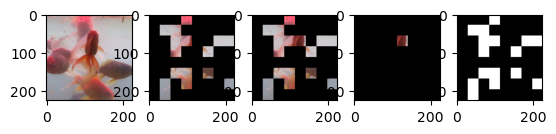

In [97]:
plot_pts([x, x_ab, x_bad, x_pertb, mask])
plt.imsave
;

In [98]:
plt.imsave(os.path.join(IMAGE_SAVETO_DIR, "x289.png"), x.numpy().transpose(1,2,0))
plt.imsave(os.path.join(IMAGE_SAVETO_DIR, "x289_ab.png"), x_ab.numpy().transpose(1,2,0))
plt.imsave(os.path.join(IMAGE_SAVETO_DIR, "x289_bad.png"), x_bad.numpy().transpose(1,2,0))
plt.imsave(os.path.join(IMAGE_SAVETO_DIR, "x289_pertb.png"), x_pertb.numpy().transpose(1,2,0))
plt.imsave(os.path.join(IMAGE_SAVETO_DIR, "m289.png"), mask.numpy().transpose(1,2,0))

In [83]:
model = model1000
with torch.no_grad():
    y_pred = model(xx)
    y_ab = model(x_ab.unsqueeze(0))
    y_bad = model(x_bad.unsqueeze(0))
    
label_true, y_pred.argmax(dim=1), y_ab.argmax(dim=1), y_bad.argmax(dim=1)

(1, tensor([1]), tensor([1]), tensor([29]))

In [84]:
model = model0250
with torch.no_grad():
    y_pred = model(xx)
    y_ab = model(x_ab.unsqueeze(0))
    y_bad = model(x_bad.unsqueeze(0))
    
label_true, y_pred.argmax(dim=1), y_ab.argmax(dim=1), y_bad.argmax(dim=1)

(1, tensor([1]), tensor([1]), tensor([1]))